Code in this notebook was inspired by the following concrete-ml documentation example

https://github.com/zama-ai/concrete-ml/blob/release/1.2.x/use_case_examples/sentiment_analysis_with_transformer/SentimentClassification.ipynb
https://github.com/zama-ai/concrete-ml/blob/release/1.3.x/docs/advanced_examples/XGBClassifier.ipynb
https://github.com/zama-ai/concrete-ml/blob/release/1.3.x/docs/advanced_examples/FullyConnectedNeuralNetworkOnMNIST.ipynb


In [1]:
import os
import time

import numpy
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from concrete.ml.sklearn import XGBClassifier
import torch
import tqdm
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
gc.collect()
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')



/home/jwaibong/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jwaibong/miniconda3/lib/python3.10/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Using device: cuda

NVIDIA GeForce RTX 3070 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
regionNameMap = {
    "California": 0,
    "Europe": 0,
    "Florida": 0,
    "New York": 0,
    "Texas": 0,
    "Virginia": 0
}


organismNameMap = {
    "Zebrafish": 1,
    "Worm": 2,
    "Fruitfly": 3
}

def getXYFromFile(filename, regionName):
    x = []
    with open(filename, 'r') as f:
        currentSeq = ""
        for line in f:
            if line[0] == '\n':
                x.append(currentSeq)
                currentSeq = ""
                if (len(x) >= 9000):
                    break
                continue
            elif line[0] == '>':
                continue
            currentSeq += line
    
    for i in range(len(x)):
        x[i] = x[i][:1024]
    
    y = [regionNameMap[regionName]] * len(x)
    return (x, y)

def getXYFromDataset(dataset, organismName):
    x = dataset["Seq"]
    for i in range(len(x)):
        x[i] = x[i][:1024]
    y = [organismNameMap[organismName]] * len(x)
    return (x,y)

In [3]:
# X_California, Y_California = getXYFromFile(f"{os.getcwd()}/ca.fasta", "California")
# print(f"Number of Sequences California: {len(X_California)}")

# X_Florida, Y_Florida = getXYFromFile(f"{os.getcwd()}/fl.fasta" "Florida")
# print(f"Number of Sequences Florida: {len(X_Florida)}")

# X_NewYork, Y_NewYork = getXYFromFile(f"{os.getcwd()}/ny.fasta", "New York")
# print(f"Number of Sequences New York: {len(X_NewYork)}")

X_Texas, Y_Texas = getXYFromFile(f"{os.getcwd()}/tx.fasta", "Texas")
print(f"Number of Sequences Texas: {len(X_Texas)}")


# X_Europe, Y_Europe = getXYFromFile(f"{os.getcwd()}/eu.fasta", "Europe")
# print(f"Number of Sequences Europe: {len(X_Europe)}")

# X_Virginia, Y_Virginia = getXYFromFile(f"{os.getcwd()}/va.fasta", "South America")
# print(f"Number of Sequences South America: {len(X_Virginia)}")

Number of Sequences Texas: 9000


In [4]:
split = "train[:9000]"
wormDataset = load_dataset("davidcechak/Worm_DNA_v0", split=split)

X_Worm, Y_Worm = getXYFromDataset(wormDataset, "Worm")
zebraFishDataset = load_dataset("davidcechak/Zebrafish_DNA_v0", split=split)
fruitFlyDataset = load_dataset("davidcechak/Fruitfly_DNA_v0", split=split)

X_Zebra, Y_Zebra = getXYFromDataset(zebraFishDataset, "Zebrafish")
X_Fly, Y_Fly = getXYFromDataset(fruitFlyDataset, "Fruitfly")


In [8]:
# x = X_California + X_Florida + X_NewYork + X_Texas + X_Europe + X_Virginia
# y = Y_California + Y_Florida + Y_NewYork + Y_Texas + Y_Europe + Y_Virginia

x = X_Texas + X_Worm + X_Zebra + X_Fly
y = Y_Texas + Y_Worm + Y_Zebra + Y_Fly

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42
)

print(len(X_train))
print(len(y_train))



32400
32400


In [5]:
# tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
# model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M").to(device)

KeyboardInterrupt: 

In [35]:
from tqdm import trange
def dna_seqs_to_tensor(
    list_X_train: list,
    model: AutoModel,
    tokenizer: AutoTokenizer,
    device: str
) -> numpy.ndarray:
    output_hidden_states_list = []

    all_chunks = []
    chunk_lengths = []
    for dna in tqdm.tqdm(list_X_train):
      chunks = [dna[i:i + 512] for i in range(0, len(dna), 512)]
      chunk_lengths.append(len(chunks))
      all_chunks.extend(chunks)


    i = 0
    step = 1
    start = 0
    stop=len(all_chunks)
    with trange(start, stop, step, desc="Encoding & Inputting into model") as t:
      j = 0
      while i < len(all_chunks):
        batch_chunks = all_chunks[i:i+chunk_lengths[j]]
        i += chunk_lengths[j]
        t.update(chunk_lengths[j])
        j += 1
        encoded_batch = tokenizer.batch_encode_plus(batch_chunks, padding='max_length', return_tensors='pt', max_length=512, truncation=True)
        input = encoded_batch['input_ids'].to(device)
        with torch.no_grad():
          outputs = model(input)[0]
          hidden_rep = torch.mean(outputs, axis=0)
          hidden_rep = torch.mean(hidden_rep, axis=0).detach().cpu().numpy()

          output_hidden_states_list.append(hidden_rep)


    return numpy.stack(output_hidden_states_list, axis=0)


In [36]:
X_test_transformer = dna_seqs_to_tensor(X_test, model, tokenizer, device)
print(X_test_transformer.shape)
X_train_transformer = dna_seqs_to_tensor(X_train, model, tokenizer, device)
print(X_train_transformer.shape)

Encoding & Inputting into model: 100%|██████████| 7200/7200 [02:03<00:00, 58.46it/s]


(3600, 768)


Encoding & Inputting into model: 100%|██████████| 64800/64800 [19:21<00:00, 55.81it/s]


(32400, 768)


In [6]:
# numpy.save('train4.npy', X_train_transformer)
# numpy.save('test4.npy', X_test_transformer)

X_train_transformer =  numpy.load('train4.npy')
X_test_transformer =  numpy.load('test4.npy')

In [38]:
xgb = XGBClassifier()

parameters = {
    "n_bits": [2, 3],
    "max_depth": [1],
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
}

grid_search = GridSearchCV(xgb, parameters, cv=3, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train_transformer, y_train)

# Check the accuracy of the best model
print(f"Best score: {grid_search.best_score_}")

# Check best hyper-parameters
print(f"Best parameters: {grid_search.best_params_}")

# Extract best model
best_model = grid_search.best_estimator_


Best score: 0.8110802469135803
Best parameters: {'max_depth': 1, 'n_bits': 3, 'n_estimators': 50, 'n_jobs': -1}


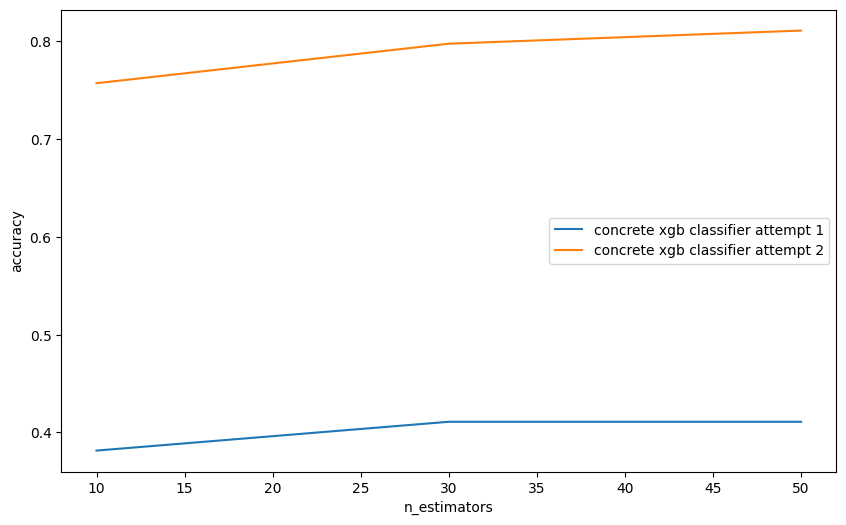

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(
    grid_search.cv_results_["param_n_estimators"][:3],
    grid_search.cv_results_["mean_test_score"][:3],
    label="concrete xgb classifier attempt 1",
)

plt.plot(
    grid_search.cv_results_["param_n_estimators"][3:],
    grid_search.cv_results_["mean_test_score"][3:],
    label="concrete xgb classifier attempt 2",
)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [40]:
y_proba_test_tfidf = best_model.predict_proba(X_test_transformer)

# Compute accuracy
y_pred_test_tfidf = numpy.argmax(y_proba_test_tfidf, axis=1)
accuracy_tfidf = numpy.mean(y_pred_test_tfidf == y_test)
print(f"Accuracy: {accuracy_tfidf:.4f}")

y_pred_covid = y_proba_test_tfidf[:, 0]
y_pred_zebrafish = y_proba_test_tfidf[:, 1]
y_pred_worm = y_proba_test_tfidf[:, 2]
y_pref_fruitfly = y_proba_test_tfidf[:, 3]

def yToBin(y, label):
    output = []
    for element in y:
        if element != label:
            output.append(0)
        else:
            output.append(1)
    return output

ap_covid_tfidf = average_precision_score(yToBin(y_test, 0), y_pred_covid)
ap_zebrafish_tfidf = average_precision_score(yToBin(y_test, 1), y_pred_zebrafish )
ap_worm_tfidf = average_precision_score(yToBin(y_test, 2), y_pred_worm )
ap_fruitfly_tfidf = average_precision_score(yToBin(y_test, 3), y_pref_fruitfly)

# print(f"Average precision score for positive class: " f"{ap_positive_tfidf:.4f}")
print(f"Average precision score for covid class: " f"{ap_covid_tfidf:.4f}")
print(f"Average precision score for zebrafish class: " f"{ap_zebrafish_tfidf:.4f}")
print(f"Average precision score for worm class: " f"{ap_worm_tfidf:.4f}")
print(f"Average precision score for fruitfly class: " f"{ap_fruitfly_tfidf:.4f}")

Accuracy: 0.8050
Average precision score for covid class: 1.0000
Average precision score for zebrafish class: 0.8713
Average precision score for worm class: 0.8460
Average precision score for fruitfly class: 0.7736


In [41]:
# Compile the model to get the FHE inference engine
# (this may take a few minutes depending on the selected model)
start = time.perf_counter()
best_model.compile(X_train_transformer)
end = time.perf_counter()
print(f"Compilation time: {end - start:.4f} seconds")


# Let's write a custom example and predict in FHE
clear_proba = best_model.predict_proba(X_test_transformer[:500], fhe="disable")

start = time.perf_counter()
decrypted_proba = best_model.predict_proba(X_test_transformer[:500], fhe="execute")
end = time.perf_counter()
fhe_exec_time = end - start
print(f"FHE inference time: {fhe_exec_time:.4f} seconds")

Compilation time: 17.9688 seconds
FHE inference time: 533.3526 seconds


In [44]:
print(f"Probabilities from the clear inference: {clear_proba}")

Probabilities from the clear inference: [[0.01563884 0.45631817 0.4300955  0.09794749]
 [0.02868643 0.34450602 0.10547257 0.52133498]
 [0.02198664 0.50630322 0.29722471 0.17448542]
 ...
 [0.92622973 0.02225555 0.01977118 0.03174355]
 [0.95971495 0.01436279 0.01068377 0.01523848]
 [0.01345715 0.18191948 0.5600588  0.24456456]]


In [42]:
print(f"Probabilities from the FHE inference: {decrypted_proba}")


Probabilities from the FHE inference: [[0.01563884 0.45631817 0.4300955  0.09794749]
 [0.02868643 0.34450602 0.10547257 0.52133498]
 [0.02198664 0.50630322 0.29722471 0.17448542]
 ...
 [0.92622973 0.02225555 0.01977118 0.03174355]
 [0.95971495 0.01436279 0.01068377 0.01523848]
 [0.01345715 0.18191948 0.5600588  0.24456456]]


In [ ]:
from concrete.ml.sklearn import NeuralNetClassifier
params = {
    "module__n_layers": 5,
    "module__n_w_bits": 4,
    "module__n_a_bits": 4,
    "module__activation_function": torch.nn.ReLU,
    "max_epochs": 15,
}
model = NeuralNetClassifier(**params)
try:
  model.fit(X=X_train_transformer, y=y_train)
except RuntimeError as e:
  print(e)


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1      159.6827       0.2389        1.3897  85.7749
      2        3.8482       0.2495        1.3935  84.9308
      3        1.3975       0.2503        1.4028  83.4168
      4        1.3989       0.2503        1.4154  94.5660
      5        1.4004       0.2503        1.4154  105.7929
      6        1.3951       0.2503        1.3942  103.6366
      7        1.3904       0.2503        1.3931  103.6058
      8        1.3905       0.2503        1.3942  102.8903
      9        1.3907       0.2503        1.4001  104.1789
     10        1.3909       0.2503        1.4001  102.0503
     11        1.3924       0.2503        1.4001  103.0224
     12        1.3931       0.2503        1.3996  104.6200


: 